# Recsys'20 Feature Engineering Tutorial Part 1
> RecSys'20 tutorial on feature engineering on a large retail dataset

- toc: true
- badges: true
- comments: true
- categories: [features, recsys, cudf, retail, bigdata]
- image: 

### Data download

In [1]:
!pip install -q -U kaggle
!pip install --upgrade --force-reinstall --no-deps kaggle
!mkdir ~/.kaggle
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d mkechinov/ecommerce-behavior-data-from-multi-category-store

     |████████████████████████████████| 61kB 2.9MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-cp37-none-any.whl size=73053 sha256=845e8bef0aaf19c5d7a8d3d66934eb5e52047f126c5e82fe7dcb5a6c1f107b0a
  Stored in directory: /root/.cache/pip/wheels/a1/6a/26/d30b7499ff85a4a4593377a87ecf55f7d08af42f0de9b60303
Successfully built kaggle
  Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12
100% 4.29G/4.29G [01:24<00:00, 50.2MB/s]
100% 4.29G/4.29G [01:24<00:00, 54.3MB/s]


In [2]:
!gdown --id 1qZIwMbMgMmgDC5EoMdJ8aI9lQPsWA3-P
!gdown --id 1x5ohrrZNhWQN4Q-zww0RmXOwctKHH9PT
!gdown --id 1-Rov9fFtGJqb7_ePc6qH-Rhzxn0cIcKB
!gdown --id 1zr_RXpGvOWN2PrWI6itWL8HnRsCpyqz8
!gdown --id 1g5WoIgLe05UMdREbxAjh0bEFgVCjA1UL

Downloading...
From: https://drive.google.com/uc?id=1qZIwMbMgMmgDC5EoMdJ8aI9lQPsWA3-P
To: /content/2019-Dec.csv.gz
2.95GB [01:08, 42.9MB/s]
Downloading...
From: https://drive.google.com/uc?id=1x5ohrrZNhWQN4Q-zww0RmXOwctKHH9PT
To: /content/2020-Jan.csv.gz
2.39GB [00:58, 40.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-Rov9fFtGJqb7_ePc6qH-Rhzxn0cIcKB
To: /content/2020-Feb.csv.gz
2.35GB [00:56, 41.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=1zr_RXpGvOWN2PrWI6itWL8HnRsCpyqz8
To: /content/2020-Mar.csv.gz
2.42GB [00:40, 60.3MB/s]
Downloading...
From: https://drive.google.com/uc?id=1g5WoIgLe05UMdREbxAjh0bEFgVCjA1UL
To: /content/2020-Apr.csv.gz
2.93GB [00:44, 66.3MB/s]


### Data extract

In [3]:
import os
import gc
import glob
import pandas as pd

In [4]:
!unzip /content/ecommerce-behavior-data-from-multi-category-store.zip
!rm /content/ecommerce-behavior-data-from-multi-category-store.zip

Archive:  /content/ecommerce-behavior-data-from-multi-category-store.zip
  inflating: 2019-Nov.csv            
  inflating: 2019-Oct.csv            


In [5]:
list_gz_files = glob.glob('/content/*.gz')
list_gz_files

['/content/2020-Jan.csv.gz',
 '/content/2020-Mar.csv.gz',
 '/content/2019-Dec.csv.gz',
 '/content/2020-Apr.csv.gz',
 '/content/2020-Feb.csv.gz']

In [6]:
for file in list_gz_files:
  print(file)
  !gunzip $file

/content/2020-Jan.csv.gz
/content/2020-Mar.csv.gz
/content/2019-Dec.csv.gz
/content/2020-Apr.csv.gz
/content/2020-Feb.csv.gz


In [7]:
snapshot = pd.read_csv("/content/2019-Oct.csv").sample(1000)
snapshot.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
19704681,2019-10-15 12:13:56 UTC,view,1307348,2053013558920217191,computers.notebook,acer,694.97,515263277,1f854496-4dae-4114-af89-4f027ba31e56
41661471,2019-10-31 09:41:21 UTC,view,12709169,2053013553559896355,NaN,michelin,68.21,512784291,caa01956-1d21-4966-8767-3fa5013ef13a
14636483,2019-10-12 06:19:13 UTC,view,11300059,2053013555531219353,electronics.telephone,texet,17.46,519299950,d67e54c3-88e4-4df2-bc37-d8c7cf656a6a
41272837,2019-10-31 03:29:40 UTC,view,11500273,2053013554625249641,NaN,jbl,94.71,543868618,a162e395-7b69-49aa-9d45-f05a60e19641
3527462,2019-10-03 20:29:36 UTC,view,1004777,2053013555631882655,electronics.smartphone,xiaomi,135.01,520834671,98d5af9f-c141-4b79-bdd1-dc9bd1d9a7cb


In [8]:
!mkdir -p /content/data/tmp
snapshot.to_csv('/content/data/tmp/snapshot.csv', index=False)

In [9]:
gc.collect()

123

### Data transform

In [1]:
import os
import gc
import glob
import pandas as pd
from pathlib import Path

In [11]:
file = '/content/data/tmp/snapshot.csv'

In [12]:
df_tmp = pd.read_csv(file)
df_tmp['session_purchase'] =  df_tmp['user_session'] + '_' + df_tmp['product_id'].astype(str)
df_purchase = df_tmp[df_tmp['event_type']=='purchase']
df_cart = df_tmp[df_tmp['event_type']=='cart']
df_purchase = df_purchase[df_purchase['session_purchase'].isin(df_cart['session_purchase'])]
df_cart = df_cart[~(df_cart['session_purchase'].isin(df_purchase['session_purchase']))]
df_cart['target'] = 0
df_purchase['target'] = 1
df = pd.concat([df_cart, df_purchase])
df = df.drop('category_id', axis=1)
df = df.drop('session_purchase', axis=1)
df.head()

,event_time,event_type,product_id,category_code,brand,price,user_id,user_session,target
55,2019-10-01 14:17:59 UTC,cart,4804055,electronics.audio.headphone,apple,189.10,522564858,c3f614f6-bdcb-46d7-ad93-18d03b0e11ba,0
75,2019-10-10 10:16:18 UTC,cart,1004708,electronics.smartphone,huawei,153.96,516882359,b513996d-0335-4337-bb4d-09c3c14ee2cf,0
133,2019-10-18 08:22:44 UTC,cart,2701288,appliances.kitchen.refrigerators,samsung,849.26,512762567,2dd77291-d54e-4d3c-a25a-2c915df9fff9,0
140,2019-10-10 04:24:55 UTC,cart,1004767,electronics.smartphone,samsung,250.93,558658709,d6c93da2-f4ee-42a1-951a-45fc52bbbf82,0
163,2019-10-12 20:19:27 UTC,cart,1004750,electronics.smartphone,samsung,196.80,549588267,d63ac7ef-d492-4034-b846-351fd2a5c32b,0


In [13]:
df[['cat_0', 'cat_1', 'cat_2']] = df['category_code'].str.split("\.", n = 3, expand = True).fillna('NA')
# df[['cat_0', 'cat_1', 'cat_2', 'cat_3']] = df['category_code'].str.split("\.", n = 3, expand = True).fillna('NA')
df['brand'] = df['brand'].fillna('NA')
df = df.drop('category_code', axis=1)
df['timestamp'] = pd.to_datetime(df['event_time'].str.replace(' UTC', ''))
df['ts_hour'] = df['timestamp'].dt.hour
df['ts_minute'] = df['timestamp'].dt.minute
df['ts_weekday'] = df['timestamp'].dt.weekday
df['ts_day'] = df['timestamp'].dt.day
df['ts_month'] = df['timestamp'].dt.month
df['ts_year'] = df['timestamp'].dt.year
df.head()

,event_time,event_type,product_id,brand,price,user_id,user_session,target,cat_0,cat_1,cat_2,timestamp,ts_hour,ts_minute,ts_weekday,ts_day,ts_month,ts_year
55,2019-10-01 14:17:59 UTC,cart,4804055,apple,189.10,522564858,c3f614f6-bdcb-46d7-ad93-18d03b0e11ba,0,electronics,audio,headphone,2019-10-01 14:17:59,14,17,1,1,10,2019
75,2019-10-10 10:16:18 UTC,cart,1004708,huawei,153.96,516882359,b513996d-0335-4337-bb4d-09c3c14ee2cf,0,electronics,smartphone,NA,2019-10-10 10:16:18,10,16,3,10,10,2019
133,2019-10-18 08:22:44 UTC,cart,2701288,samsung,849.26,512762567,2dd77291-d54e-4d3c-a25a-2c915df9fff9,0,appliances,kitchen,refrigerators,2019-10-18 08:22:44,8,22,4,18,10,2019
140,2019-10-10 04:24:55 UTC,cart,1004767,samsung,250.93,558658709,d6c93da2-f4ee-42a1-951a-45fc52bbbf82,0,electronics,smartphone,NA,2019-10-10 04:24:55,4,24,3,10,10,2019
163,2019-10-12 20:19:27 UTC,cart,1004750,samsung,196.80,549588267,d63ac7ef-d492-4034-b846-351fd2a5c32b,0,electronics,smartphone,NA,2019-10-12 20:19:27,20,19,5,12,10,2019


In [14]:
list_files = glob.glob('/content/*.csv')
list_files

['/content/2020-Apr.csv',
 '/content/2019-Nov.csv',
 '/content/2020-Jan.csv',
 '/content/2019-Dec.csv',
 '/content/2020-Mar.csv',
 '/content/2019-Oct.csv',
 '/content/2020-Feb.csv']

In [15]:
def process_files(df_tmp, chunkname):
    df_tmp['session_purchase'] =  df_tmp['user_session'] + '_' + df_tmp['product_id'].astype(str)
    df_purchase = df_tmp[df_tmp['event_type']=='purchase']
    df_cart = df_tmp[df_tmp['event_type']=='cart']
    df_purchase = df_purchase[df_purchase['session_purchase'].isin(df_cart['session_purchase'])]
    df_cart = df_cart[~(df_cart['session_purchase'].isin(df_purchase['session_purchase']))]
    df_cart['target'] = 0
    df_purchase['target'] = 1
    df = pd.concat([df_cart, df_purchase])
    df = df.drop('category_id', axis=1)
    df = df.drop('session_purchase', axis=1)
    # df[['cat_0', 'cat_1', 'cat_2', 'cat_3']] = df['category_code'].str.split("\.", n = 3, expand = True).fillna('NA')
    df['brand'] = df['brand'].fillna('NA')
    # df = df.drop('category_code', axis=1)
    df['timestamp'] = pd.to_datetime(df['event_time'].str.replace(' UTC', ''))
    df['ts_hour'] = df['timestamp'].dt.hour
    df['ts_minute'] = df['timestamp'].dt.minute
    df['ts_weekday'] = df['timestamp'].dt.weekday
    df['ts_day'] = df['timestamp'].dt.day
    df['ts_month'] = df['timestamp'].dt.month
    df['ts_year'] = df['timestamp'].dt.year
    df.to_csv(chunkname, index=False)

In [2]:
base_path_silver = "/content/data/silver"
!mkdir -p $base_path_silver

In [24]:
for idx, chunk in enumerate(list_files[:2]):
  chunkname = os.path.join(base_path_silver, Path(chunk).stem + '-' + str(idx) + '.csv')
  print(chunkname)

/content/data/silver/2020-Apr-0.csv
/content/data/silver/2019-Nov-1.csv


In [26]:
chunksize = 10 ** 6

for file in list_files:
    print(file)
    for idx, chunk in enumerate(pd.read_csv(file, chunksize=chunksize)):
      chunkname = os.path.join(base_path_silver, Path(file).stem + '-' + str(idx) + '.csv')
      print(chunkname)
      if not os.path.exists(chunkname):
        process_files(chunk, chunkname)

/content/2020-Apr.csv
/content/data/silver/2020-Apr-0.csv
/content/data/silver/2020-Apr-1.csv
/content/data/silver/2020-Apr-2.csv
/content/data/silver/2020-Apr-3.csv
/content/data/silver/2020-Apr-4.csv
/content/data/silver/2020-Apr-5.csv
/content/data/silver/2020-Apr-6.csv
/content/data/silver/2020-Apr-7.csv
/content/data/silver/2020-Apr-8.csv
/content/data/silver/2020-Apr-9.csv
/content/data/silver/2020-Apr-10.csv
/content/data/silver/2020-Apr-11.csv
/content/data/silver/2020-Apr-12.csv
/content/data/silver/2020-Apr-13.csv
/content/data/silver/2020-Apr-14.csv
/content/data/silver/2020-Apr-15.csv
/content/data/silver/2020-Apr-16.csv
/content/data/silver/2020-Apr-17.csv
/content/data/silver/2020-Apr-18.csv
/content/data/silver/2020-Apr-19.csv
/content/data/silver/2020-Apr-20.csv
/content/data/silver/2020-Apr-21.csv
/content/data/silver/2020-Apr-22.csv
/content/data/silver/2020-Apr-23.csv
/content/data/silver/2020-Apr-24.csv
/content/data/silver/2020-Apr-25.csv
/content/data/silver/2020-

In [27]:
for file in list_files:
  !rm $file

In [3]:
list_chunks = glob.glob(os.path.join(base_path_silver,'*.csv'))
list_chunks[:10]

['/content/data/silver/2020-Jan-40.csv',
 '/content/data/silver/2019-Dec-54.csv',
 '/content/data/silver/2019-Oct-27.csv',
 '/content/data/silver/2019-Nov-12.csv',
 '/content/data/silver/2020-Mar-36.csv',
 '/content/data/silver/2020-Apr-14.csv',
 '/content/data/silver/2020-Feb-40.csv',
 '/content/data/silver/2019-Nov-3.csv',
 '/content/data/silver/2020-Mar-3.csv',
 '/content/data/silver/2020-Apr-39.csv']

In [31]:
!cd $base_path_silver && zip /content/data_silver.zip ./*.csv

  adding: 2019-Dec-0.csv (deflated 76%)
  adding: 2019-Dec-10.csv (deflated 76%)
  adding: 2019-Dec-11.csv (deflated 76%)
  adding: 2019-Dec-12.csv (deflated 76%)
  adding: 2019-Dec-13.csv (deflated 76%)
  adding: 2019-Dec-14.csv (deflated 76%)
  adding: 2019-Dec-15.csv (deflated 76%)
  adding: 2019-Dec-16.csv (deflated 77%)
  adding: 2019-Dec-17.csv (deflated 76%)
  adding: 2019-Dec-18.csv (deflated 76%)
  adding: 2019-Dec-19.csv (deflated 76%)
  adding: 2019-Dec-1.csv (deflated 76%)
  adding: 2019-Dec-20.csv (deflated 76%)
  adding: 2019-Dec-21.csv (deflated 76%)
  adding: 2019-Dec-22.csv (deflated 76%)
  adding: 2019-Dec-23.csv (deflated 77%)
  adding: 2019-Dec-24.csv (deflated 76%)
  adding: 2019-Dec-25.csv (deflated 77%)
  adding: 2019-Dec-26.csv (deflated 76%)
  adding: 2019-Dec-27.csv (deflated 77%)
  adding: 2019-Dec-28.csv (deflated 77%)
  adding: 2019-Dec-29.csv (deflated 76%)
  adding: 2019-Dec-2.csv (deflated 76%)
  adding: 2019-Dec-30.csv (deflated 76%)
  adding: 2019-Dec-

In [32]:
!cp data_silver.zip /content/drive/MyDrive/Recommendation

In [4]:
lp = []
for file in list_chunks:
  lp.append(pd.read_csv(file))

In [5]:
df = pd.concat(lp)
df.shape

(16742775, 16)

In [35]:
df.head()

,event_time,event_type,product_id,category_code,brand,price,user_id,user_session,target,timestamp,ts_hour,ts_minute,ts_weekday,ts_day,ts_month,ts_year
0,2020-01-23 04:32:33 UTC,cart,100039953,appliances.personal.massager,kivi,267.44,512913139,9bebab16-bce8-43cd-ac97-f763ee4664dd,0,2020-01-23 04:32:33,4,32,3,23,1,2020
1,2020-01-23 04:32:36 UTC,cart,1004767,construction.tools.light,samsung,226.27,549154456,659387e4-032e-4e71-8b0b-3b90f0538f14,0,2020-01-23 04:32:36,4,32,3,23,1,2020
2,2020-01-23 04:32:38 UTC,cart,1003306,construction.tools.light,apple,614.79,585624798,41a24f4f-afb8-4342-ae6f-003aa968f82f,0,2020-01-23 04:32:38,4,32,3,23,1,2020
3,2020-01-23 04:32:38 UTC,cart,4804055,sport.bicycle,apple,192.07,525860806,70b5ed9a-4395-481e-9f91-d811ced8a4c3,0,2020-01-23 04:32:38,4,32,3,23,1,2020
4,2020-01-23 04:32:43 UTC,cart,1005100,construction.tools.light,samsung,141.06,599724791,bc35693d-9c73-457f-a7ef-8ced2f0bb729,0,2020-01-23 04:32:43,4,32,3,23,1,2020


In [2]:
# df2 = df['category_code'].str.split("\.", n=3, expand=True).fillna('NA')
# df2.columns = ['cat_{}'.format(x+1) for x in df2.columns]
# df2.to_parquet('/content/data/silver_l2/df_cat.parquet', index=False)

In [6]:
df_test = df[df['ts_month']==4]
df_valid = df[df['ts_month']==3]
df_train = df[(df['ts_month']!=3)&(df['ts_month']!=4)]

In [7]:
df_train.shape, df_valid.shape, df_test.shape

((11495245, 16), (2466048, 16), (2781482, 16))

In [8]:
!mkdir -p /content/data/silver_l2
df_train.to_parquet('/content/data/silver_l2/train.parquet', index=False)
df_valid.to_parquet('/content/data/silver_l2/valid.parquet', index=False)
df_test.to_parquet('/content/data/silver_l2/test.parquet', index=False)

### Data load

In [9]:
!cd /content/data/silver_l2 && zip /content/data_silver_l2.zip ./*.parquet
!cp /content/data_silver_l2.zip /content/drive/MyDrive/Recommendation

  adding: test.parquet (deflated 24%)
  adding: train.parquet (deflated 25%)
  adding: valid.parquet (deflated 24%)


In [1]:
import pandas as pd

df_train = pd.read_parquet('/content/data/silver_l2/train.parquet')
df_valid = pd.read_parquet('/content/data/silver_l2/valid.parquet')
df_test = pd.read_parquet('/content/data/silver_l2/test.parquet')

df = pd.concat([df_train, df_valid, df_test],ignore_index=True)

df.shape

(16742775, 16)

### EDA

In [2]:
import IPython

import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [3]:
df.dtypes

event_time        object
event_type        object
product_id         int64
category_code     object
brand             object
price            float64
user_id            int64
user_session      object
target             int64
timestamp         object
ts_hour            int64
ts_minute          int64
ts_weekday         int64
ts_day             int64
ts_month           int64
ts_year            int64
dtype: object

In [4]:
df['timestamp'] = pd.to_datetime(df['timestamp'])

In [5]:
df.target.mean()

0.36775719676099095

In [6]:
df['event_type'].value_counts(normalize=True)

cart        0.632243
purchase    0.367757
Name: event_type, dtype: float64

Around 37.0% of datapoints are purchases. Lets take a look on the sparsity of the data.

In [7]:
print('# of datapoints:' + str(df.shape))
print('# of unique users:' + str(df['user_id'].drop_duplicates().shape))
print('# of unique products:' + str(df['product_id'].drop_duplicates().shape))
print('# of unique sessions:' + str(df['user_session'].drop_duplicates().shape))

# of datapoints:(16742775, 16)
# of unique users:(3584809,)
# of unique products:(214907,)
# of unique sessions:(10715053,)


In [8]:
def plot_sparse(df, col):
    stats = df[[col, 'target']].groupby(col).agg(['count', 'mean', 'sum'])
    stats = stats.reset_index()
    stats.columns = [col, 'count', 'mean', 'sum']
    stats_sort = stats['count'].value_counts().reset_index()
    stats_sort = stats_sort.sort_values('index')
    plt.figure(figsize=(15,4))
    plt.bar(stats_sort['index'].astype(str).values[0:20], stats_sort['count'].values[0:20])
    plt.title('Frequency of ' + str(col))
    plt.xlabel('Number frequency')
    plt.ylabel('Frequency')

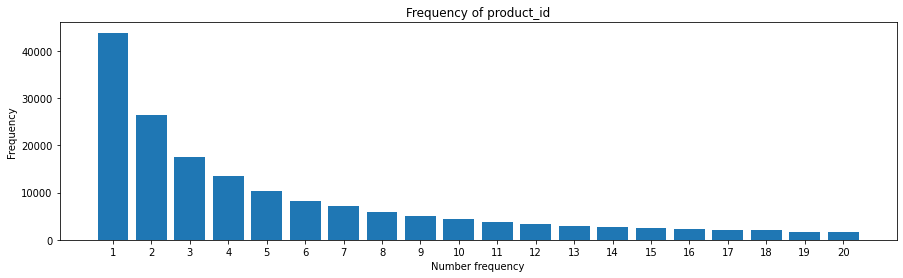

In [9]:
plot_sparse(df, 'product_id')

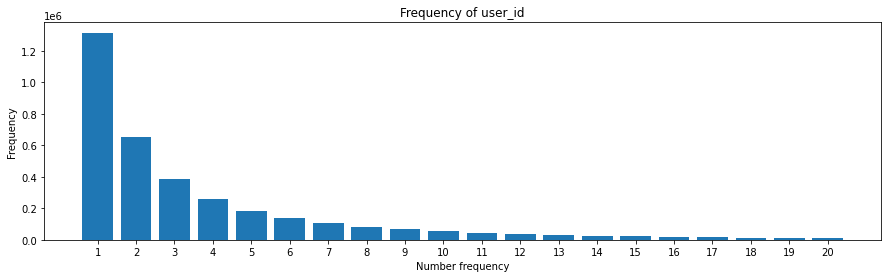

In [10]:
plot_sparse(df, 'user_id')

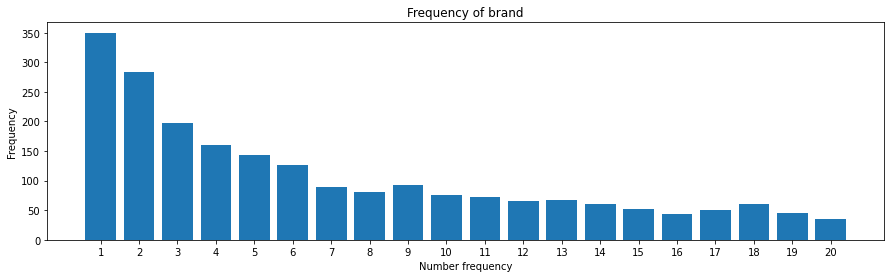

In [11]:
plot_sparse(df, 'brand')

We can observe following pattern:
- There are ~45000 products which appear only once in the dataset
- There are 1200000 users which appear only once in the dataset
- There are 350 brands which appears only once in the dataset

The sparsity is important for understanding which features can be better used in a model. Product_id and User_id have many values which appear only once and the model is less able to learn a good patterns from them.
On the other hand, brands has many observations and can be leveraged for prediction.

In [12]:
def plot_top20(df, col):
    stats = df[[col, 'target']].groupby(col).agg(['count', 'mean', 'sum'])
    stats = stats.reset_index()
    stats.columns = [col, 'count', 'mean', 'sum']
    stats = stats.sort_values('count', ascending=False)
    fig, ax1 = plt.subplots(figsize=(15,4))
    ax2 = ax1.twinx()
    ax1.bar(stats[col].astype(str).values[0:20], stats['count'].values[0:20])
    ax1.set_xticklabels(stats[col].astype(str).values[0:20], rotation='vertical')
    ax2.plot(stats['mean'].values[0:20], color='red')
    ax2.set_ylim(0,1)
    ax2.set_ylabel('Mean Target')
    ax1.set_ylabel('Frequency')
    ax1.set_xlabel(col)
    ax1.set_title('Top20 ' + col + 's based on frequency')

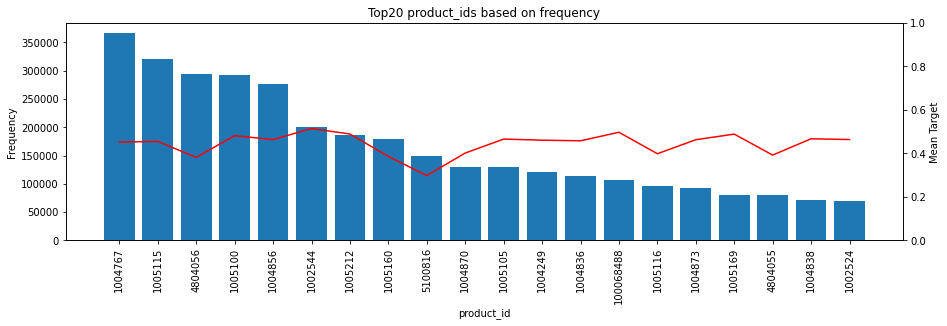

In [13]:
plot_top20(df, 'product_id')

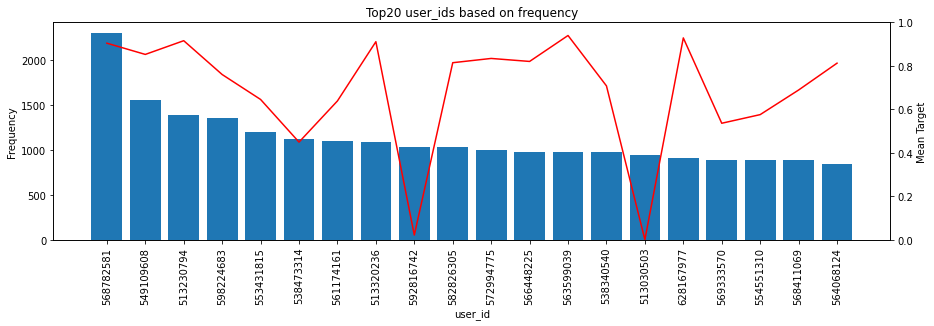

In [14]:
plot_top20(df, 'user_id')

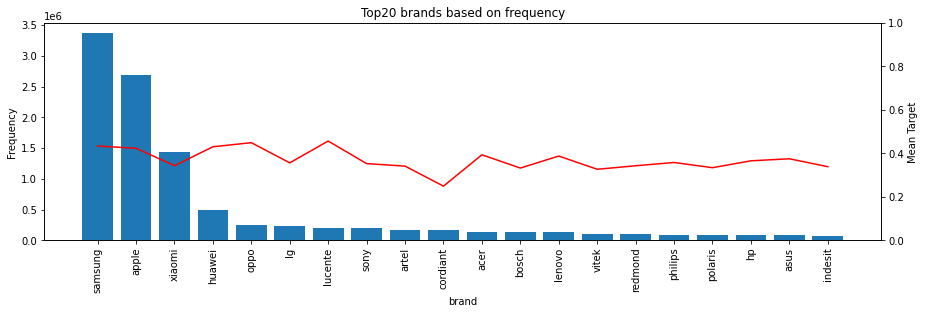

In [15]:
plot_top20(df, 'brand')

In [3]:
df['date'] = pd.to_datetime(df['timestamp']).dt.date

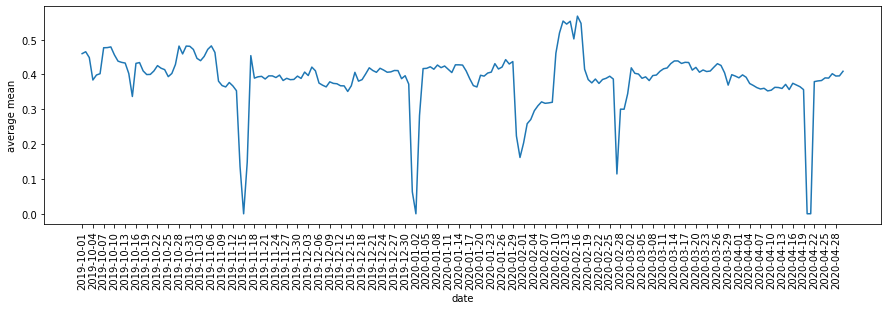

In [4]:
plt.figure(figsize=(15,4))
plt.plot(df[['date', 'target']].groupby('date').target.mean())
plt.ylabel('average mean')
plt.xlabel('date')
plt.xticks(df[['date', 'target']].groupby('date').target.mean().index[::3], rotation='vertical')
print('')

In [5]:
df[['date', 'target']].groupby('date').target.mean().sort_values().head(20)

date
2019-11-15    0.000000
2020-01-02    0.000000
2020-04-20    0.000096
2020-04-21    0.000147
2020-01-01    0.063013
2020-02-27    0.114378
2019-11-14    0.135596
2019-11-16    0.147902
2020-01-31    0.161678
2020-02-01    0.203322
2020-01-30    0.223492
2020-02-02    0.258615
2020-02-03    0.270665
2020-01-03    0.282014
2020-02-04    0.295918
2020-02-29    0.300146
2020-02-28    0.300432
2020-02-05    0.310188
2020-02-07    0.317174
2020-02-08    0.318376
Name: target, dtype: float64

- We explored the data and saw the different raw features available in the dataset.
- We analzyed basic statistics of the raw features and saw long-tail distribution for categorical features (user, item, brand)
- Some categorical features (categories) have high occurances
- In general, we see that categorical features have variance in the target, which we can leverage to engineer more powerful features